In [ ]:
! pip install chess
! pip install zstandard

In [ ]:
! pip install requests
! pip install bs4

In [ ]:
! pip install pandas

In [ ]:
! pip install ipyparallel

In [ ]:
! pip install pathos

In [ ]:
"""Prépraration des dossiers"""
import os
try:
    os.mkdir('zstd_files/')
except:
    pass
try:
    os.mkdir('pgn_files/')
except:
    pass
try:
    os.mkdir('Data/')
except:
    pass
try:
    os.mkdir('Blackmar-Diemer Gambit')
except:
    pass

In [ ]:
"""Cette partie de code permet de télécharger les fichiers pgn de la base de données de Lichess"""
import requests
from bs4 import BeautifulSoup
import re

def download_files(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Pgn file downloaded successfully: {save_path}")
    else:
        print("Failed to download pgn file.")

def get_torrent_links(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    download_links = []
    for link in soup.find_all('a', href=True):
        href:str = link['href']
        if href.endswith('.zst'):
            taille =  int(link.next_sibling.strip().split(' ')[-1])
            if taille <=259216467:
                download_links.append(href)
    return download_links

def pgn_files():
    url = 'https://database.lichess.org/standard/'
    response = requests.get(url)
    if response.status_code == 200:
        pgn_links = get_torrent_links(response.content)
        for pgn_link in pgn_links:
            pgn_url = url + pgn_link
            save_path = re.search(r'[^/]+\.zst', pgn_link).group(0)
            save_path = f"zstd_files/{save_path}"
            download_files(pgn_url, save_path)
    else:
        print("Failed to fetch HTML content.")

pgn_files()

In [ ]:
"""Cette partie est pour décompresser les fichiers zstd."""
import zstandard as zstd
import os
def decompress_zstd(input_file, output_file):
    with open(input_file, 'rb') as compressed_file:
        with open(output_file, 'wb') as decompressed_file:
            dctx = zstd.ZstdDecompressor()
            reader = dctx.stream_reader(compressed_file)
            while True:
                chunk = reader.read(65536)
                if not chunk:
                    break
                decompressed_file.write(chunk)
for file in os.listdir('zstd_files'):
    basename = file.replace('.zst', '')
    input_file = f'zstd_files/{file}'
    output_file = f'pgn_files/{basename}'
    if not input_file.endswith('zst'):
        continue
    print(input_file, output_file)
    decompress_zstd(input_file, output_file)

In [10]:
"""Cette partie de code permet de traiter les fichiers pgn pour extraire les parties avec la gambit Blackmar-Diemer"""
import chess.pgn
import pandas as pd
import os
from pathos.multiprocessing import ProcessingPool as Pool
import re

def get_black_deimer(png_file:str):
    """Extract games with Blackmar-Diemer Gambit from a PGN file."""
    outputfile = png_file.replace('pgn_files/', '')
    outputfile = outputfile.replace('db_standard_rated_', '')
    outputfile = 'Blackmar-Diemer Gambit/' + outputfile
    if os.path.exists(outputfile):
        return outputfile
    pgn = open(png_file)
    black_deimer_gambit =['d2d4', 'd7d5', 'e2e4', 'd5e4', 'b1c3', 'g8f6', 'f2f3', 'e4f3']
    with open(outputfile, 'w') as f:
        pass
    number_of_games = 0
    number_of_games_with_black_deimer_gambit = 0
    while True:
        is_in = False
        game = chess.pgn.read_game(pgn)
        if game is None:
            break
        number_of_games += 1
        if  'Blackmar-Diemer Gambit' not in game.headers['Opening']:
            continue
        if game.headers['ECO'].strip() != 'D00':
            continue
        if game.headers['Result'] != '1-0':
            continue
        for index,move in enumerate(game.mainline_moves()):
            if  index ==  len(black_deimer_gambit):
                is_in = True
                break
            if move.uci() != black_deimer_gambit[index]:
                break
        if is_in:
            number_of_games_with_black_deimer_gambit += 1
            with open(outputfile, 'a') as f:
                f.write(str(game)+'\n\n')
    print(f"Number of games: {number_of_games}")
    print(f"Number of games with Blackmar-Diemer Gambit: {number_of_games_with_black_deimer_gambit}")
    return outputfile


def generate_csv_from_pgn(black_deimer_file:str):
    """Generate a CSV file from a PGN file containing games with Blackmar-Diemer Gambit."""
    pgn_file = open(black_deimer_file)
    csvfile = black_deimer_file.replace('Blackmar-Diemer Gambit/', '')
    csvfile = csvfile.replace('.pgn', '.csv')
    csvfile = 'Data/' + csvfile
    games = {"move 1": [], "move 2": [], "move 3": [], "move 4": [], "move 5": [], "move 6": [], "move 7": [], "move 8": [], "move 9": [], "move 10": [], "move 11": [], "move 12": []}

    while True:
        pgn = chess.pgn.read_game(pgn_file)
        if pgn is None:
            break
        pgn_str = str(pgn)
        moves:str = pgn_str.splitlines()[-1]
        pattern = r'\{.*?\}'
        to_clean:list = re.findall(pattern, moves)
        pattern = r' \$\d+'
        to_clean.extend(re.findall(pattern, moves))
        pattern = r' \d+\.\.\. '
        to_clean.extend(re.findall(pattern, moves))
        for clean in to_clean:
            moves:str = moves.replace(clean, '')
        pattern = r'([BNKQR]?[a-h]?[1-8]?x?[a-h][1-8][\+#]?|O-O|O-O-O) ([BNKQR]?[a-h]?[1-8]?x?[a-h][1-8][\+#]?|O-O|O-O-O)?'
        moves:list[str] = re.findall(pattern, moves)
        for i,move in enumerate(moves.copy()):
            moves[i] = (move[0] + ' ' + move[1]).strip()
        if len(moves) < 12:
            continue
        moves = moves[0:12]
        for i in range(len(moves)):
            games[f"move {i + 1}"].append(moves[i])
    games = pd.DataFrame(games)
    print(games)
    games.to_csv(csvfile, index=False)


def proccess(pgn_file:str):
    """Process a PGN file to extract games with Blackmar-Diemer Gambit and generate a CSV file with the moves using multiprocessing."""
    print(f"Processing file: {pgn_file}")
    outputfile = get_black_deimer(pgn_file)
    generate_csv_from_pgn(outputfile)

def combine_all_data():
    games:pd.DataFrame = pd.DataFrame({"move 1": [], "move 2": [], "move 3": [], "move 4": [], "move 5": [], "move 6": [], "move 7": [], "move 8": [], "move 9": [], "move 10": [], "move 11": [], "move 12": []})
    for file in os.listdir('Data'):
        if "alldata" in file:
            continue
        if file.endswith('.csv'):
            csv_file = f"Data/{file}"
            _ = pd.read_csv(csv_file)
            games = pd.concat([games, _], ignore_index=True)
    print("Before drop duplicates")
    print(games.shape)
    games.drop_duplicates(inplace=True)
    print("After drop duplicates")
    print(games.shape)
    games.to_csv('Data/Black-Diemer Gambit-alldata.csv', index=False)
    print("before drop invalid moves")
    print(games.shape)
    pattern = r'([BNKQR]?[a-h]?[1-8]?x?[a-h][1-8][\+#]?|O-O|O-O-O) ([BNKQR]?[a-h]?[1-8]?x?[a-h][1-8][\+#]?|O-O|O-O-O)'
    games = games[games['move 12'].str.match(pattern)]
    print("after drop invalid moves")
    print(games.shape)
    games.to_csv('Data/Black-Diemer Gambit-alldata-test.csv', index=False)

print("""ce code suivant est en cours d'execution s'execute par le multiprocessing.
Ce qui pose des problemes dans les notebooks jupyter.
Si vous voulez l'executer il y a un script python dans le meme dossier que ce notebook process_data.py.
Si vous voulez l'executer dans ce notebook, il faut decommenter les lignes suivantes.""")
# files = []
# for file in os.listdir('pgn_files'):
#     if file.endswith('pgn'):
#         files.append(f'pgn_files/{file}')
# num_processes = int(os.cpu_count()/2)
# pool = Pool(processes=num_processes)
# pool.map(proccess, files)
# combine_all_data()


ce code suivant est en cours d'execution s'execute par le multiprocessing.
Ce qui pose des problemes dans les notebooks jupyter.
Si vous voulez l'executer il y a un script python dans le meme dossier que ce notebook.
Si vous voulez l'executer dans ce notebook, il faut decommenter les lignes suivantes.


In [ ]:
from itertools import chain, combinations

def apriori_algorithm(df:pd.DataFrame, min_support:float, min_confidence:float) -> tuple[pd.DataFrame, pd.DataFrame]:
    """This function implements the Apriori algorithm for frequent itemset mining.
    It takes a DataFrame of transactions and returns DataFrames of frequent itemsets and association rules.
    The 'min_support' and 'min_confidence' parameters are the minimum support and confidence thresholds, respectively."""
    def get_support(itemset, transactions) -> float:
        return sum(1 for transaction in transactions if itemset.issubset(transaction)) / len(transactions)
    def get_candidates(prev_freq_itemsets:list[set], length:int) -> list:
        items = set(chain(*prev_freq_itemsets))
        return [set(comb) for comb in combinations(items, length)]
    transactions:list = df.astype(str).values.tolist()
    transactions:list[set] = [set(transaction) for transaction in transactions]
    # Initial step: Find all frequent 1-itemsets
    itemsets:list[set] = [set([item]) for item in set(chain(*transactions))]
    current_freq_itemsets = [itemset for itemset in itemsets if get_support(itemset, transactions) >= min_support]
    all_freq_itemsets = current_freq_itemsets.copy()
    k = 2
    while current_freq_itemsets:
        candidates = get_candidates(current_freq_itemsets, k)
        current_freq_itemsets = [candidate for candidate in candidates if get_support(candidate, transactions) >= min_support]
        all_freq_itemsets.extend(current_freq_itemsets)
        k += 1
    def generate_rules(freq_itemsets:list[set], transactions:list[set], min_confidence:float) -> list:
        rules = []
        for itemset in freq_itemsets:
            for consequent_length in range(1, len(itemset)):
                for consequent in combinations(itemset, consequent_length):
                    antecedent = itemset.difference(consequent)
                    if antecedent:
                        support_antecedent = get_support(antecedent, transactions)
                        support_itemset = get_support(itemset, transactions)
                        confidence = support_itemset / support_antecedent
                        if confidence >= min_confidence:
                            rules.append((antecedent, set(consequent), confidence, support_itemset))
        return rules
    rules = generate_rules(all_freq_itemsets, transactions, min_confidence)
    # Convert results to DataFrames for better readability
    freq_itemsets_df = pd.DataFrame([(itemset, get_support(itemset, transactions)) for itemset in all_freq_itemsets],
                                    columns=['Itemset', 'Support'])
    rules_df = pd.DataFrame(rules, columns=['Antecedent', 'Consequent', 'Confidence', 'Support'])
    return freq_itemsets_df, rules_df

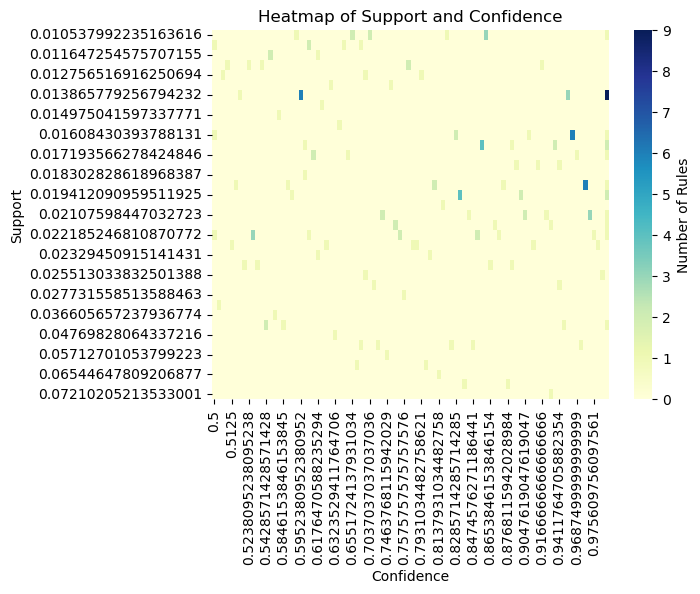

In [13]:
"""Cette partie de code permet de générer les règles d'association et les itemsets fréquents"""
import pandas as pd
data = pd.read_csv('Data/Black-Diemer Gambit-alldata-test.csv')
data.drop(list(data.columns[:4]), axis=1, inplace=True)
min_support = 0.01
min_confidence = 0.5
freq_itemsets, rules = apriori_algorithm(data, min_support, min_confidence)
freq_itemsets.sort_values('Support', ascending=False).to_csv('Data/frequent_itemsets.csv', index=False)
rules.sort_values(['Confidence', 'Support'], ascending=False).to_csv('Data/rules.csv', index=False)


In [ ]:
"""Cette partie de code permet de tester la génération de règles d'association et d'itemsets fréquents
avec une base de données plus petite."""
import pandas as pd
data = pd.read_csv('Data/D00.csv')
data.drop(list(data.columns[:4]), axis=1, inplace=True)
min_support = 0.02
min_confidence = 0.5
freq_itemsets, rules = apriori_algorithm(data, min_support, min_confidence)
freq_itemsets.sort_values('Support', ascending=False).to_csv('Data/frequent_itemsets_test.csv', index=False)
rules.sort_values(['Confidence', 'Support'], ascending=False).to_csv('Data/rules_test.csv', index=False)